Done by Sidharth Sreeja Prashanth, GUID: 2796382s

The task is to train two deep neural network which can take a 100x100 pixel images with a cell nuclei in the centre of the image and classify it into one of the following types which are shown in the figures above:

<li>Normal epithelial cell nuclei with label 0.
<li>Cancer epithelial cell nuclei with label 1.
<li>Muscle cell nuclei with label 2.
<li>Immune leukocyte cell nuclei with label 3.

In [1]:
!pip install captum
!pip install matplotlib==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pandas as pd
from skimage import io, transform
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)

from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os, collections , torch 
import numpy as np
import seaborn as sns

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# train_csv = pd.read_csv("/kaggle/input/deep-learning-for-msc-2022-23/train.csv")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

3.5.3


In [3]:
## Set device to use GPU if available.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## 1) Model Design

As per the problem statement, two deep neural networks are to be made and trained on the data.
<li> ConvNet Network with 8 layers<li>
<li> Modified existing torchvision model which is pre-trained on ImageNet <li>

The first model is made from scratch using nn.Sequential().
The second model is obtained by modifying a pretrained ResNet18 model so that it can classify data into 4 required classes.


In [4]:


## Celldataset class is created.It reads the training data labels and filenames and creates a dataset object that can be indexed to return an image and  label. 

class CellDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data.values
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx): 
        
        image_name, label = self.data[idx]
        image_name = os.path.join(self.root_dir, image_name)
        img = io.imread(image_name)
    

        if self.transform:
            img = self.transform(img)
            
        
        return img, label
    
## Making a ConvNet model
Net1 = nn.Sequential(collections.OrderedDict([
          ('conv1', nn.Conv2d(3,32,3,padding=1)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(32,64,3,padding=1)),
          ('relu2', nn.ReLU()),
          # Put in a linear layers ...
          ('flatten', nn.Flatten()),                                          
          ('fc1', nn.Linear(64*100*100,200)),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(200,4)),
        ]))
          
torch.cuda.empty_cache()

## Getting a resnet18 model
Net2 = models.resnet18(pretrained=True)
## when using to.device, it is moved to the gpu if it is available.
Net2 = Net2.to(device)

## We extract the final linear layer and change the number of output layers to 4, as it is a 4 way classification problem.
num_inputs = Net2.fc.in_features
Net2.fc = nn.Linear(num_inputs, 4)
Net2.fc = Net2.fc.cuda() 


img_transform = transforms.Compose([transforms.ToPILImage(), 
                               transforms.ToTensor(), 
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [5]:
data = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv')
##split data into training and validation data.
train_data , validation_data  = train_test_split(data, stratify= data.Label, test_size=0.2)

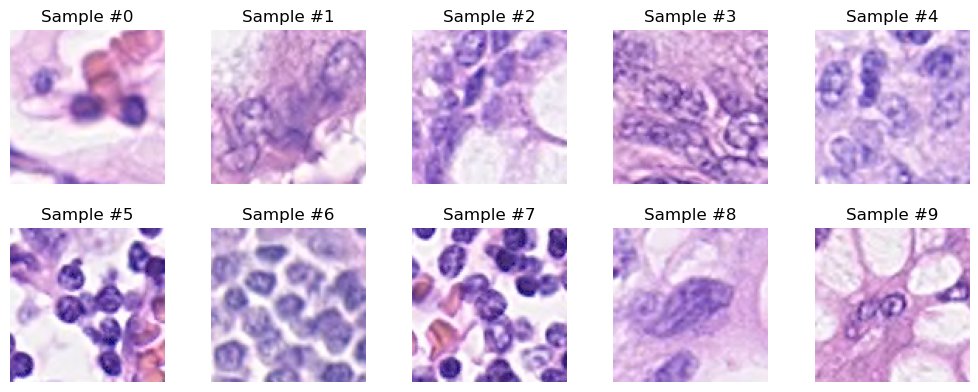

In [6]:
train_dataset = CellDataset(train_data, root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train')

## test whether images get extracted properly.
fig  = plt.figure(figsize=(10, 10))

for i in range(0,10):
    sample = train_dataset[i]
    # print(i, sample['image'].shape, sample['label'])
    ax = plt.subplot(5, 5, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0], cmap='gray')

    

This part is just to test whether the images are getting extracted properly. It extracts and displays 10 samples from the training dataset.

## 2) Training, Validation and Testing

Datasets are created from the training data using train_test_splt and datasets are created. A new test Dataset class is made for the test data. Seperate loops are written for test, train and validation.
In the training loop, loss and accuracy curves are plotted and the accuracy and the number of images classified is shown in the validation loop. The test loop is run after, which writes out the classified labels and filenmes to the submission.csv file. Based on the validation score, the test loop is used only one one of the models, which will be the one with higher accuracy.

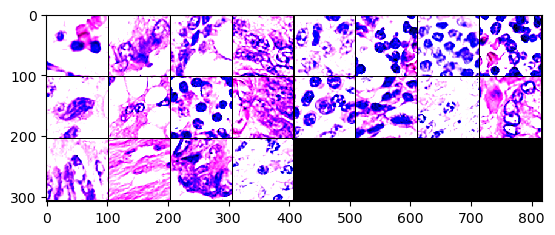

In [7]:
## datasets for training and validation
train_dataset = CellDataset(train_data, root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train' , transform= img_transform)
validation_dataset = CellDataset(validation_data, root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train', transform= img_transform)


## date time to keep track of epochs
import datetime
epoch_print_gap = 1

## dataloader for training data and optimizers for training.
loader = DataLoader(train_dataset, batch_size = 20)
optimizer = optim.SGD(Net1.parameters(), lr= 0.01)
optimizer2 = optim.SGD(Net2.parameters(), lr= 0.001 , momentum = 0.95)

loss_fn = nn.CrossEntropyLoss()

## Extract data from loader and test
images, labels = next(iter(loader))
grid = utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')


## Training loop that trains model and prints the Loss and Accuracy Curves.
def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)

    loss_vals = [] # loss history
    acc_vals = [] # accuracy history
    x_epoch = [] # epoch numbers
    
    def get_accuracy(model, data_loader):
        # function to calculate the accuracy of the model on the data loader
        correct = 0
        total = 0
        with torch.no_grad():
            for img,label in data_loader:
                outputs = model(img.to(device))
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == label.to(device)).sum().item()
        return 100 * correct / total
    
    def plot_curve(current_epoch):
        # function to plot the loss and accuracy curves
        x_epoch.append(current_epoch)
        plt.subplot(2, 1, 1)
        if current_epoch == n_epochs:
            plt.plot(x_epoch, loss_vals, 'b-', label='loss')
            plt.legend()
        else:
            plt.plot(x_epoch, loss_vals, 'b-')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        
        plt.subplot(2, 1, 2)
        if current_epoch == n_epochs:
            plt.plot(x_epoch, acc_vals, 'r-', label='accuracy')
            plt.legend()
        else:
            plt.plot(x_epoch, acc_vals, 'r-')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        
        # plt.show()

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for img,label in train_loader:
            outputs = model(img.to(device))

            
            loss = loss_fn(outputs, label.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

        loss_vals.append(loss_train / len(train_loader))
        acc_vals.append(get_accuracy(model, train_loader))    

        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
        plot_curve(epoch)   
    plt.show()

2023-03-27 11:57:52.419286 Epoch 1, Training loss 233.87608310580254
2023-03-27 11:58:30.323349 Epoch 2, Training loss 136.25758762657642
2023-03-27 11:59:04.230625 Epoch 3, Training loss 110.77953515201807
2023-03-27 11:59:35.378712 Epoch 4, Training loss 91.93450352549553
2023-03-27 12:00:04.515268 Epoch 5, Training loss 84.35861292481422
2023-03-27 12:00:33.544366 Epoch 6, Training loss 67.00524799898267
2023-03-27 12:01:02.406247 Epoch 7, Training loss 50.20159093756229
2023-03-27 12:01:31.498732 Epoch 8, Training loss 40.723081635078415
2023-03-27 12:02:00.602705 Epoch 9, Training loss 25.56689497223124
2023-03-27 12:02:30.571261 Epoch 10, Training loss 20.24838460702449
2023-03-27 12:03:00.007983 Epoch 11, Training loss 16.246764746378176
2023-03-27 12:03:29.107212 Epoch 12, Training loss 18.64028908300679
2023-03-27 12:03:57.893586 Epoch 13, Training loss 14.222915607489995
2023-03-27 12:04:27.050039 Epoch 14, Training loss 4.368195894843666
2023-03-27 12:04:56.367759 Epoch 15, 

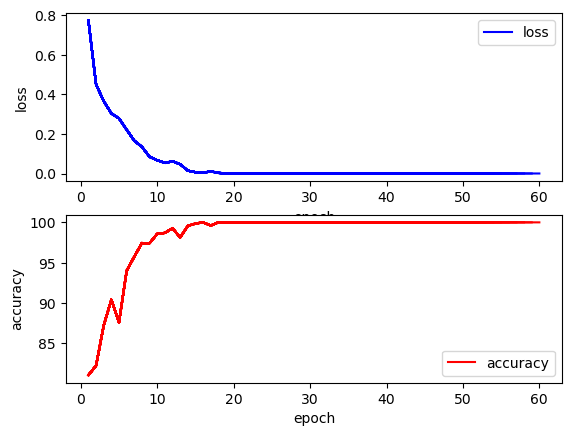

In [8]:
training_loop(
    n_epochs = 60,
    optimizer = optimizer,
    model = Net1,
    device = device,
    loss_fn = loss_fn,
    train_loader = loader,
)

These are the Loss and Accuracy curves for Model 1 on training data. It is as expected, as the epochs go on, the training loss goes in decreasing, which implies the model is learning well from the data. The accuracy increasing and approaching 100. Training is going on successfully.

2023-03-27 12:28:16.908684 Epoch 1, Training loss 116.22242453414947
2023-03-27 12:28:48.193449 Epoch 2, Training loss 16.377637602272443
2023-03-27 12:29:18.270731 Epoch 3, Training loss 3.511988318510703
2023-03-27 12:29:47.984103 Epoch 4, Training loss 0.4788507875127834
2023-03-27 12:30:17.955299 Epoch 5, Training loss 0.24344920620933408
2023-03-27 12:30:48.172076 Epoch 6, Training loss 0.16933663636882557
2023-03-27 12:31:19.208187 Epoch 7, Training loss 0.13481619426602265
2023-03-27 12:31:50.974545 Epoch 8, Training loss 0.11246865814973717
2023-03-27 12:32:21.530932 Epoch 9, Training loss 0.09665856062565581
2023-03-27 12:32:54.465382 Epoch 10, Training loss 0.08479514864666271
2023-03-27 12:33:27.887859 Epoch 11, Training loss 0.0755567779779085
2023-03-27 12:34:00.617004 Epoch 12, Training loss 0.06814520097395871
2023-03-27 12:34:32.643774 Epoch 13, Training loss 0.06205963421052729
2023-03-27 12:35:03.968262 Epoch 14, Training loss 0.05696768151210563
2023-03-27 12:35:35.2

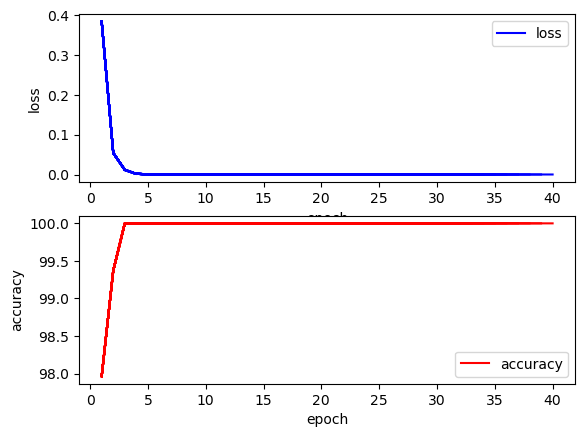

In [9]:
training_loop(
    n_epochs = 40,
    optimizer = optimizer2,
    model = Net2,
    device = device,
    loss_fn = loss_fn,
    train_loader = loader,
)


These are the Loss and Accuracy curves for Model 2 on training data. It is as expected, as the epochs go on, the training loss goes in decreasing, which implies the model is learning well from the data. The accuracy increasing and approaching 100. Training is going on successfully.

In [10]:

## another dataset class for test data, which doesn't have labels or a .csv file. THe input arguments are the root directory (containing the test images) and the transform.
class testset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = [str(i)+'.png' for i in range(10001, 15042)]
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx): 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.data[idx])
        img = io.imread(img_name)
        if self.transform:
            img = self.transform(img)
        
        # print(img_name)
        return img


test_dataset = testset(root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test', transform= img_transform)
test_dataset[0].shape
test_loader = DataLoader(test_dataset)

import torch.nn.functional as F
valid_loader = DataLoader(validation_dataset, batch_size = 20)

In [11]:
def plot_confusion_matrix(confusion_matrix, labels , mod):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(f"Confusion Matrix {mod}")
    plt.show()
    
    
    
def valid_loop(model, device, test_loader, mod):
    label_names = ['Normal epithelial cell nuclei ',
                    'Cancer epithelial cell nuclei',
                    'Muscle cell nuclei',
                    'Immune leukocyte cell nuclei ']
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    conf_matrix = torch.zeros(4, 4)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for t, p in zip(target.view(-1), pred.view(-1)):
                conf_matrix[t.long(), p.long()] += 1

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plot_confusion_matrix(conf_matrix, label_names,mod)
    
    
def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            labels.append(torch.argmax(output, 1).item())
            # test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            # pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # correct += pred.eq(target.view_as(pred)).sum().item()
            # print(output)
    # test_loss /= len(test_loader.dataset)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))
    names = [str(i)+'.png' for i in range(10001, 15042)]
#     print(labels)
    out = pd.DataFrame({'Filename': names, 'Label': labels})
    out.to_csv('submission.csv', index=False)
    print("Done")



Test set: Average loss: 1.2049, Accuracy: 1273/1512 (84%)



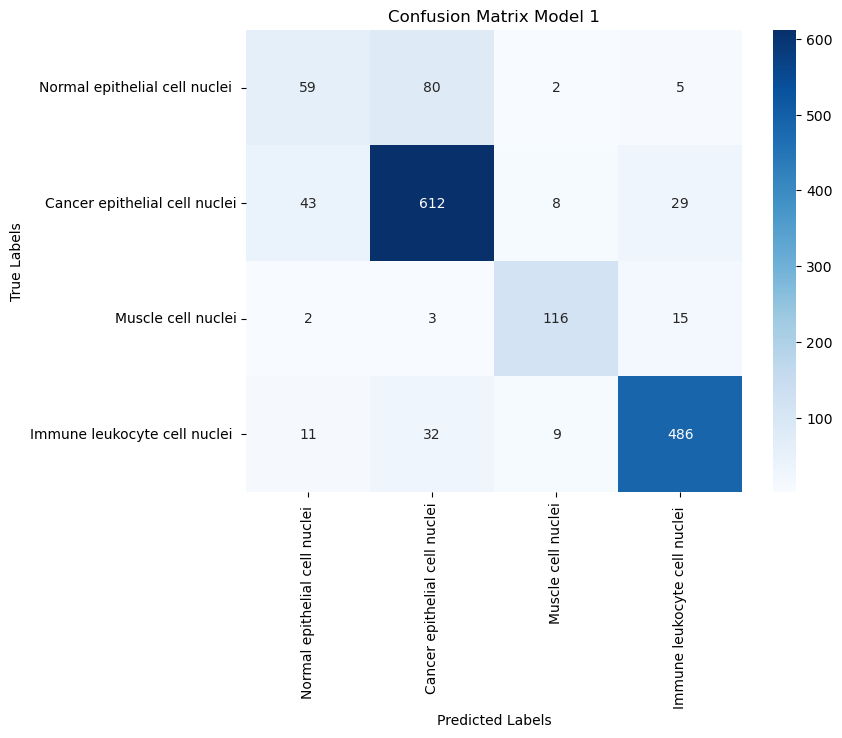


Test set: Average loss: 0.1407, Accuracy: 1468/1512 (97%)



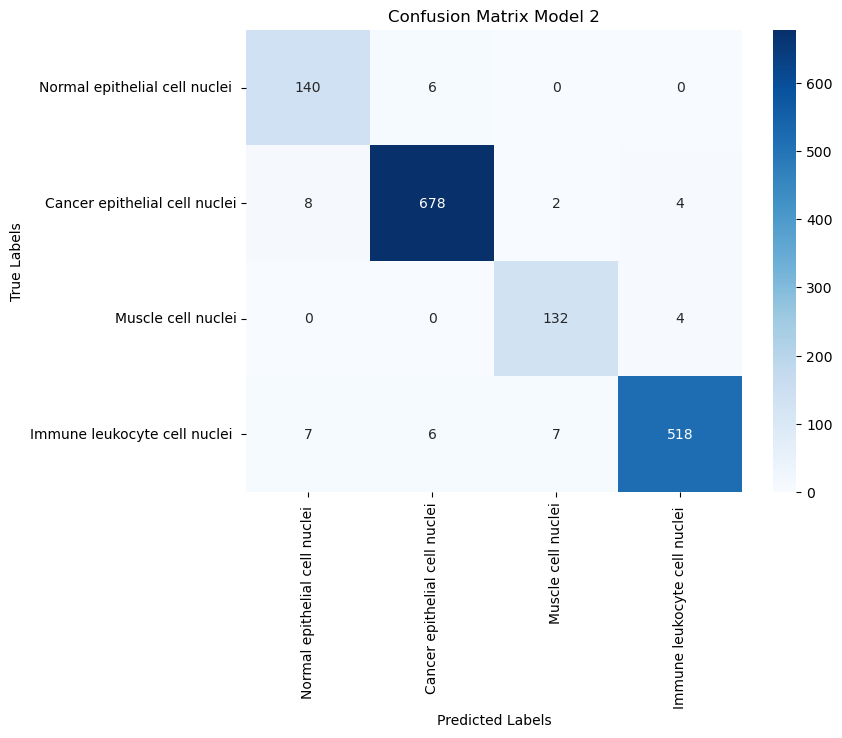

Done


In [12]:

valid_loop(Net1, device, valid_loader, 'Model 1')
# test_loop(Net1, device, test_loader)

valid_loop(Net2, device, valid_loader, 'Model 2')
test_loop(Net2, device, test_loader)

From the confusion matrix, it is clear that Model 2 performs better on validation data as the matrix has highest values along the diagonals and there is better contrast between values in diagonal and non diagonal elements.

## 3) Hyperparameter Tuning


Ray Tune is a tool that helps us find the best hyperparameters for our machine learning model by running many trials in parallel and using smart algorithms to guide the search. Here, the hyperparameter selected for optimization is the learning rate. Custom training loop and validation loops are written, and these are put in a wrapper function which accepts an argument "config". Config is a dictionary containing the selected hyperparameters as the keys and their ranges defined using raytune as values. In the wrapper function, the hyperparameters are passed as " config["name_of_parameter"] instead of values as done earlier. I have chosen to run trials for 10 epochs. Then we use tune.run() to run the trails. Within the training loop, tune.report() is used to report the losses in each epoch to ray tune.
The best values of the hyperparameter, accuracy and the loss after trail are printed after.

### a) Hyperparameter Tuning for Model 2

In [13]:
## Imports for tuning

from functools import partial
from torch.utils.data import random_split
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [14]:
def tune_loop(config, checkpoint_dir=None):
    
    ### define model
    net = models.resnet18(pretrained=True)
    
    inputs = net.fc.in_features
    net.fc = nn.Linear(inputs, 4)
    net.fc = net.fc.cuda() 
    
    ## set device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    
    ## lr from config, which is a dict
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    ## access the global loaders .
    global loader 
    global valid_loader
    
    
    ## training loop
    for epoch in range(10):
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  
                print("[%d, %5d] loss: %.3f" %
                      (epoch + 1, i + 1, running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        with torch.no_grad():
            for data in valid_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

    ### passing the parametrs into config.. here, jut the learning rate.
config = {
    "lr": tune.loguniform(1e-4, 1e-1)
}

# Run the tuning with Ray Tune
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(
    parameter_columns=["lr"],
    metric_columns=["loss", "accuracy", "training_iteration"])

result = tune.run(
    partial(tune_loop),
    resources_per_trial={"cpu": 1, "gpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter)



# best_trained_model = Net()
# best_trained_model.load_state_dict(torch.load(os.path.join(
#     best_trial.checkpoint.value, "checkpoint"))[0])

2023-03-27 12:50:33,600	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,
E0327 12:50:37.284104307      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 12:50:38 (running for 00:00:00.40)
Memory usage on this node: 3.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+-------------+
| Trial name            | status   | loc             |          lr |
|-----------------------+----------+-----------------+-------------|
| tune_loop_f8c44_00000 | RUNNING  | 172.19.2.2:2041 | 0.000109425 |
| tune_loop_f8c44_00001 | PENDING  |                 | 0.0445771   |
| tune_loop_f8c44_00002 | PENDING  |                 | 0.0894751   |
| tune_loop_f8c44_00003 | PENDING  |                 | 0.0144028   |
| tune_loop_f8c44_00004 | PENDING  |                 | 0.

(func pid=2041) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2041)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2041) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2041)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:50:49 (running for 00:00:11.28)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+-------------+
| Trial name            | status   | loc             |          lr |
|-----------------------+----------+-----------------+-------------|
| tune_loop_f8c44_00000 | RUNNING  | 172.19.2.2:2041 | 0.000109425 |
| tune_loop_f8c44_00001 | PENDING  |                 | 0.0445771   |
| tune_loop_f8c44_00002 | PENDING  |                 | 0.0894751   |
| tune_loop_f8c44_00003 | PENDING  |                 | 0.0144028   |
| tune_loop_f8c44_00004 | PENDING  |                 | 0.

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
tune_loop_f8c44_00000,0.89881,2023-03-27_12-54-54,True,,90463c85abfd4367b16a514f4cfbb62f,5b3471f01495,10,0.27861,172.19.2.2,2041,True,250.624,22.8321,250.624,1679921694,0,,10,f8c44_00000,0.00621915
tune_loop_f8c44_00001,0.714947,2023-03-27_12-55-27,True,,691a3edbeee1466b9f2cf0daad43b0d0,5b3471f01495,1,0.964844,172.19.2.2,2287,True,26.6435,26.6435,26.6435,1679921727,0,,1,f8c44_00001,0.00704527
tune_loop_f8c44_00002,0.704365,2023-03-27_12-56-01,True,,5e4e33db6ec84bb7909f97e714497e41,5b3471f01495,1,2.00203,172.19.2.2,2355,True,27.1761,27.1761,27.1761,1679921761,0,,1,f8c44_00002,0.0107503
tune_loop_f8c44_00003,0.882275,2023-03-27_12-56-56,True,,a0df70df556547e88e7ce1b5a89fb31d,5b3471f01495,2,0.571867,172.19.2.2,2423,True,49.6229,22.9523,49.6229,1679921816,0,,2,f8c44_00003,0.0054996
tune_loop_f8c44_00004,0.734788,2023-03-27_12-57-29,True,,09f79cad8fe94cc297627456cc88f5bd,5b3471f01495,1,1.07576,172.19.2.2,2508,True,26.8589,26.8589,26.8589,1679921849,0,,1,f8c44_00004,0.00527167
tune_loop_f8c44_00005,0.76455,2023-03-27_12-58-26,True,,c01752c93c4b49bd8e4f5cf9677dc480,5b3471f01495,2,0.648854,172.19.2.2,2578,True,49.9857,23.3215,49.9857,1679921906,0,,2,f8c44_00005,0.00558162
tune_loop_f8c44_00006,0.681217,2023-03-27_12-58-58,True,,6dcd8e700483404aa69a63fe4c3e4d36,5b3471f01495,1,1.58817,172.19.2.2,2665,True,26.7647,26.7647,26.7647,1679921938,0,,1,f8c44_00006,0.00571775
tune_loop_f8c44_00007,0.896825,2023-03-27_13-00-42,True,,cf7ff6de4a8743a18a999496aa01ecf3,5b3471f01495,4,0.314859,172.19.2.2,2735,True,97.3547,23.9069,97.3547,1679922042,0,,4,f8c44_00007,0.00546598
tune_loop_f8c44_00008,0.686508,2023-03-27_13-01-16,True,,7a9c29228bb448b6a3f5c63ec120dd36,5b3471f01495,1,1.26264,172.19.2.2,2865,True,27.803,27.803,27.803,1679922076,0,,1,f8c44_00008,0.00553656
tune_loop_f8c44_00009,0.921296,2023-03-27_13-05-21,True,,5c6a4278edb149ea8882ee873357acea,5b3471f01495,10,0.265356,172.19.2.2,2936,True,238.056,23.505,238.056,1679922321,0,,10,f8c44_00009,0.00829101


== Status ==
Current time: 2023-03-27 12:51:20 (running for 00:00:42.74)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5380074303401144
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status   | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+----------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00000 | RUNNING  | 172.19.2.2:2041 | 0.000109425 | 0.538007 |   0.811508 |                    1 |
| tune_loop_f8c44_00001 | PENDING  |                 | 0.0445

(func pid=2287) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2287)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2287) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2287)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:55:05 (running for 00:04:28.08)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.27969122094739424 | Iter 4.000: -0.3137727491557598 | Iter 2.000: -0.40259976390945285 | Iter 1.000: -0.5380074303401144
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------+------------+-----------------+-------------+---------+------------+----------------------+
| Trial name            | status     | loc             |          lr |    loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+---------+------------+----------------------|
| tune_loop_f8c44_00001 | RUNNING    | 172.19.2.2:2287 | 0.0445771   |         |            |                    

(func pid=2355) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2355)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2355) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2355)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:55:38 (running for 00:05:01.09)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.27969122094739424 | Iter 4.000: -0.3137727491557598 | Iter 2.000: -0.40259976390945285 | Iter 1.000: -0.7514257770227759
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00002 | RUNNING    | 172.19.2.2:2355 | 0.0894751   |          |            |                

(func pid=2423) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2423)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2423) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2423)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:56:12 (running for 00:05:34.26)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.27969122094739424 | Iter 4.000: -0.3137727491557598 | Iter 2.000: -0.40259976390945285 | Iter 1.000: -0.9648441237054373
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00003 | RUNNING    | 172.19.2.2:2423 | 0.0144028   |          |            |                

(func pid=2508) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2508)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2508) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2508)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:57:07 (running for 00:06:30.17)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.27969122094739424 | Iter 4.000: -0.3137727491557598 | Iter 2.000: -0.487233504554943 | Iter 1.000: -0.7514257770227759
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00004 | RUNNING    | 172.19.2.2:2508 | 0.0635919   |          |            |                  

(func pid=2578) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2578)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2578) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2578)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:57:35 (running for 00:06:57.40)
Memory usage on this node: 3.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.27969122094739424 | Iter 4.000: -0.3137727491557598 | Iter 2.000: -0.487233504554943 | Iter 1.000: -0.9648441237054373
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00005 | RUNNING    | 172.19.2.2:2578 | 0.07103     |          |            |                  

(func pid=2665) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2665)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2665) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2665)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:58:37 (running for 00:07:59.23)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.27969122094739424 | Iter 4.000: -0.3137727491557598 | Iter 2.000: -0.5718672452004332 | Iter 1.000: -0.8784080737907636
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00006 | RUNNING    | 172.19.2.2:2665 | 0.091186    |          |            |                 

(func pid=2735) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2735)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2735) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2735)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:59:10 (running for 00:08:32.30)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.27969122094739424 | Iter 4.000: -0.3137727491557598 | Iter 2.000: -0.5718672452004332 | Iter 1.000: -0.9648441237054373
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00007 | RUNNING    | 172.19.2.2:2735 | 0.000122348 |          |            |                 

(func pid=2865) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2865)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2865) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2865)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 13:00:53 (running for 00:10:16.10)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.27969122094739424 | Iter 4.000: -0.31431610240159846 | Iter 2.000: -0.487233504554943 | Iter 1.000: -0.8784080737907636
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00008 | RUNNING    | 172.19.2.2:2865 | 0.0525151   |          |            |                 

(func pid=2936) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2936)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2936) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2936)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 13:01:27 (running for 00:10:50.15)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.27969122094739424 | Iter 4.000: -0.31431610240159846 | Iter 2.000: -0.487233504554943 | Iter 1.000: -0.9648441237054373
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00009 | RUNNING    | 172.19.2.2:2936 | 0.000228734 |          |            |                      |
| tu

2023-03-27 13:05:21,168	INFO tune.py:763 -- Total run time: 883.92 seconds (883.22 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 13:05:21 (running for 00:14:43.23)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.270642159126797 | Iter 4.000: -0.3137727491557598 | Iter 2.000: -0.40259976390945285 | Iter 1.000: -0.8784080737907636
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_12-50-37
Number of trials: 10/10 (10 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_f8c44_00000 | TERMINATED | 172.19.2.2:2041 | 0.000109425 | 0.27861  |   0.89881  |                   10 |
| tune_loop_f8c44_

In [15]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

Best trial config: {'lr': 0.00022873436682672662}
Best trial final validation loss: 0.2653557438844521
Best trial final validation accuracy: 0.9212962962962963


This shows the best value for the learning rate for Model 2, and the validation loss and accuracy.
This wasn't used to train the model as a better accuracy was achieved with manually chosen value for learning rate.

### b) Hyperparameter Tuning for Model 1

In [16]:
def tune_loop(config, checkpoint_dir=None):
    
    ## define model
    net = nn.Sequential(collections.OrderedDict([
          ('conv1', nn.Conv2d(3,32,3,padding=1)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(32,64,3,padding=1)),
          ('relu2', nn.ReLU()),
          # Put in a linear layers ...
          ('flatten', nn.Flatten()),                                          
          ('fc1', nn.Linear(64*100*100,200)),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(200,4)),
        ]))
    
    ## set device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    
    ## lr from config, which is a dict
    optimizer = optim.SGD(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    
    ## get the global loaders.
    global loader 
    global valid_loader
    

    ## training loop  
    for epoch in range(10):
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  
                print("[%d, %5d] loss: %.3f" %
                      (epoch + 1, i + 1, running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        with torch.no_grad():
            for data in valid_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")
config = {
    "lr": tune.loguniform(1e-4, 1e-1)
}

# Run the tuning with Ray Tune
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(
    parameter_columns=["lr"],
    metric_columns=["loss", "accuracy", "training_iteration"])

result = tune.run(
    partial(tune_loop),
    resources_per_trial={"cpu": 1, "gpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter)

== Status ==
Current time: 2023-03-27 13:05:21 (running for 00:00:00.26)
Memory usage on this node: 3.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_13-05-21
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+-------------+
| Trial name            | status   | loc             |          lr |
|-----------------------+----------+-----------------+-------------|
| tune_loop_07c96_00000 | RUNNING  | 172.19.2.2:3173 | 0.0016335   |
| tune_loop_07c96_00001 | PENDING  |                 | 0.0104887   |
| tune_loop_07c96_00002 | PENDING  |                 | 0.00735636  |
| tune_loop_07c96_00003 | PENDING  |                 | 0.00340679  |
| tune_loop_07c96_00004 | PENDING  |                 | 0.

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
tune_loop_07c96_00000,0.849206,2023-03-27_13-09-41,True,,bc5b7ab6dd484bac925f0c916b854f2b,5b3471f01495,10,0.413063,172.19.2.2,3173,True,252.657,24.4762,252.657,1679922581,0,,10,07c96_00000,0.00778365
tune_loop_07c96_00001,0.767857,2023-03-27_13-10-17,True,,0db2062633b44708b44272d1cb01de62,5b3471f01495,1,0.578041,172.19.2.2,3451,True,28.5459,28.5459,28.5459,1679922617,0,,1,07c96_00001,0.00765157
tune_loop_07c96_00002,0.838624,2023-03-27_13-13-43,True,,fb14854063b6455f9a969b085c8e41f4,5b3471f01495,8,0.488584,172.19.2.2,3519,True,199.167,24.5205,199.167,1679922823,0,,8,07c96_00002,0.020601
tune_loop_07c96_00003,0.813492,2023-03-27_13-14-44,True,,8b43c8acdf7347b6bee536c5def46287,5b3471f01495,2,0.471986,172.19.2.2,3728,True,54.3523,24.5898,54.3523,1679922884,0,,2,07c96_00003,0.00627542
tune_loop_07c96_00004,0.847884,2023-03-27_13-18-18,True,,4f84126b224f4de3a7e3718c4c357e10,5b3471f01495,8,0.543158,172.19.2.2,3813,True,207.438,24.219,207.438,1679923098,0,,8,07c96_00004,0.0134008
tune_loop_07c96_00005,0.801587,2023-03-27_13-19-19,True,,331e13320f634e7fa757d7395987cc3a,5b3471f01495,2,0.497113,172.19.2.2,4029,True,52.9585,24.1703,52.9585,1679923159,0,,2,07c96_00005,0.00652122
tune_loop_07c96_00006,0.753968,2023-03-27_13-19-59,True,,6768cc826f654cffb6ec39136d7e2a5e,5b3471f01495,1,0.646897,172.19.2.2,4118,True,32.9138,32.9138,32.9138,1679923199,0,,1,07c96_00006,0.0047965
tune_loop_07c96_00007,0.776455,2023-03-27_13-20-41,True,,026ea1ca8da0463ba276c5fdc1125c65,5b3471f01495,1,0.53714,172.19.2.2,4192,True,34.8754,34.8754,34.8754,1679923241,0,,1,07c96_00007,0.00848126
tune_loop_07c96_00008,0.75463,2023-03-27_13-21-18,True,,620d94d0c63d4021928843dc66d86255,5b3471f01495,1,0.614088,172.19.2.2,4269,True,31.3139,31.3139,31.3139,1679923278,0,,1,07c96_00008,0.00900698
tune_loop_07c96_00009,0.765212,2023-03-27_13-21-59,True,,d3e5f5c4b5b64657a74600696414e99a,5b3471f01495,1,0.73006,172.19.2.2,4339,True,32.8718,32.8718,32.8718,1679923319,0,,1,07c96_00009,0.00838995


== Status ==
Current time: 2023-03-27 13:06:02 (running for 00:00:40.56)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5415158328649244
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_13-05-21
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status   | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+----------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_07c96_00000 | RUNNING  | 172.19.2.2:3173 | 0.0016335   | 0.541516 |   0.782407 |                    1 |
| tune_loop_07c96_00001 | PENDING  |                 | 0.0104

2023-03-27 13:21:59,235	INFO tune.py:763 -- Total run time: 997.67 seconds (997.53 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 13:21:59 (running for 00:16:37.54)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.48858387547692184 | Iter 4.000: -0.40943545725588737 | Iter 2.000: -0.4706065046944116 | Iter 1.000: -0.5393281322168677
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/6.25 GiB heap, 0.0/3.13 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_loop_2023-03-27_13-05-21
Number of trials: 10/10 (10 TERMINATED)
+-----------------------+------------+-----------------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-------------+----------+------------+----------------------|
| tune_loop_07c96_00000 | TERMINATED | 172.19.2.2:3173 | 0.0016335   | 0.413063 |   0.849206 |                   10 |
| tune_loop_07c9

In [17]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

Best trial config: {'lr': 0.0016335007807523894}
Best trial final validation loss: 0.4130632409237717
Best trial final validation accuracy: 0.8492063492063492


This shows the best value for the learning rate for Model 1, and the validation loss and accuracy.
This wasn't used to train the model as a better accuracy was achieved with manually chosen value for learning rate.


#### Result
Tuned hyperparameters didn't yield satisfactory results, so I proceeded to data Interpretation.

## 4) Interpretation

Now, we will be using algortihms from Captum to apply model interpretability algorithms on both our models using an image from the train_dataset and visualize the attributions for each pixel by overlaying them on the image.

.

The interpretation algorithms used are Integrated Gradients (with and without noise tunnel), GradientShap, and Occlusion.Noise tunnel is used here to smoothen the attributions after adding Gaussian noise to each input sample.

###  Interpretation using Captum for Models 1 and 2

#### Gradient-based attribution
The attributions for Inegrated gradients are calculated and visualized here.

For Model 1 
Predicted: 3 ( 1.0 )


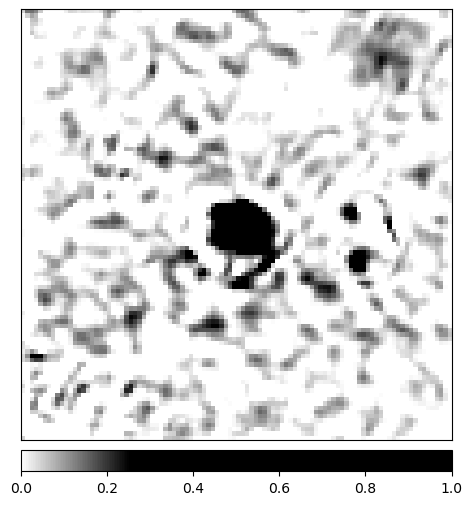

For Model 2 
Predicted: 3 ( 1.0 )


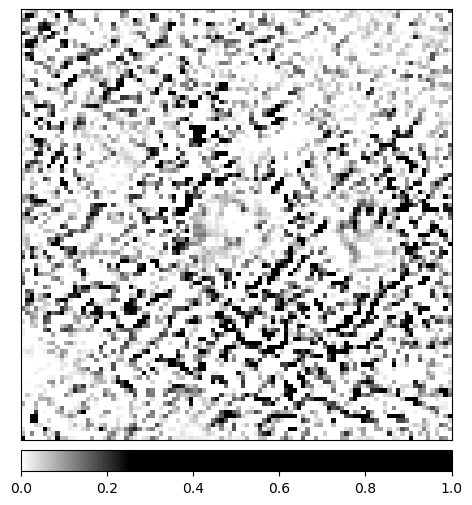

In [18]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap


intg = IntegratedGradients(Net1)
intg2 = IntegratedGradients(Net2)
inp, lb = train_dataset[0]
input = inp.unsqueeze(0)
input = input.to(device)
# print(input.shape)

output = Net1(input)
output2 = Net2(input)

output = F.softmax(output, dim=1)
output2 = F.softmax(output2, dim=1)

prediction_score, pred_label_idx = torch.topk(output, 1)
prediction_score2, pred_label_idx2 = torch.topk(output2, 1)

print("For Model 1 ")
pred_label_idx.squeeze_()
predicted_label = torch.argmax(output,1).item()
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')



attributions_ig = intg.attribute(input, target=pred_label_idx, n_steps=200)
attributions_ig2 = intg2.attribute(input, target=pred_label_idx2, n_steps=200)


default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


fig = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
print("For Model 2 ")
pred_label_idx2.squeeze_()
predicted_label2 = torch.argmax(output2,1).item()
print('Predicted:', predicted_label2, '(', prediction_score2.squeeze().item(), ')')


fig = viz.visualize_image_attr(np.transpose(attributions_ig2.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

This image shows the heat map of the attributions of an image classifier using Integrated Gradients. The attributions indicate how important each pixel of the input image is for the model’s prediction of a certain class. The darker the pixel, the higher the attribution score. We can kind of see which parts are important for the decision the model makes.

For Model 1 


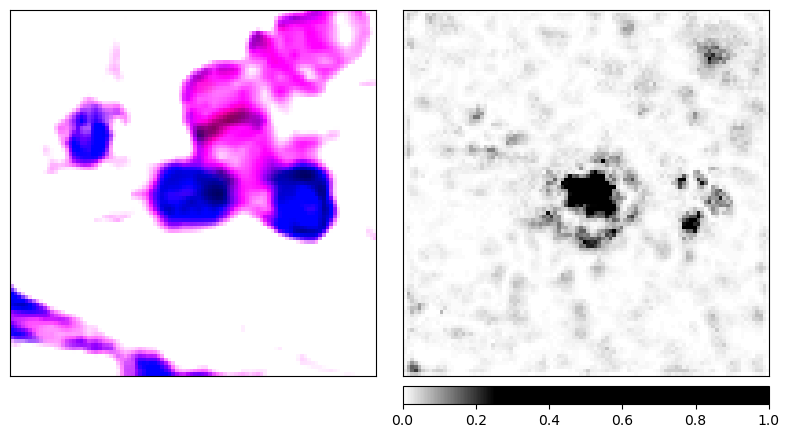

For Model 2 


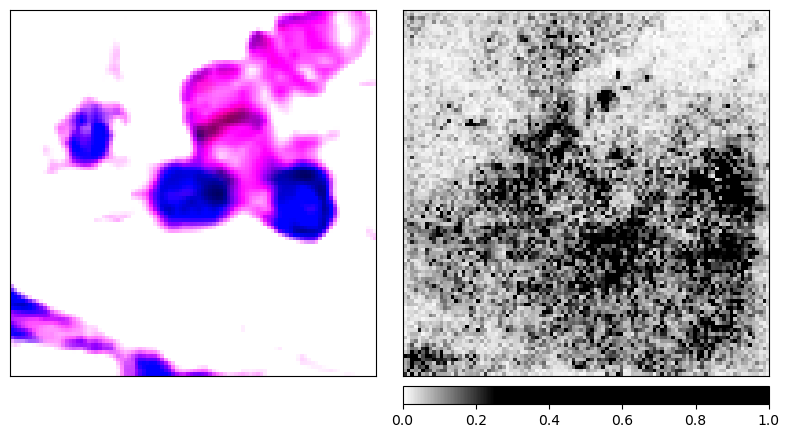

In [19]:
noise_tunnel = NoiseTunnel(intg)
noise_tunnel2 = NoiseTunnel(intg2)


attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
attributions_ig_nt2 = noise_tunnel2.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx2)

print("For Model 1 ")
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

print("For Model 2 ")

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

This image shows the heat map of the attributions of two image classifiers using Integrated Gradients with NoiseTunnel

For Model 1 


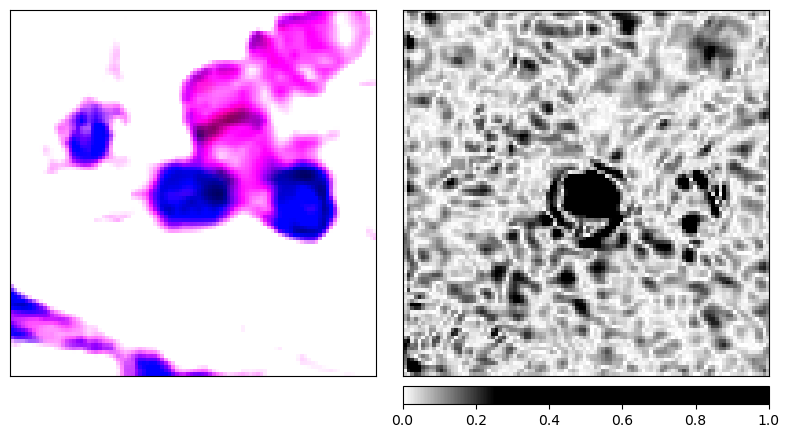

For Model 2 


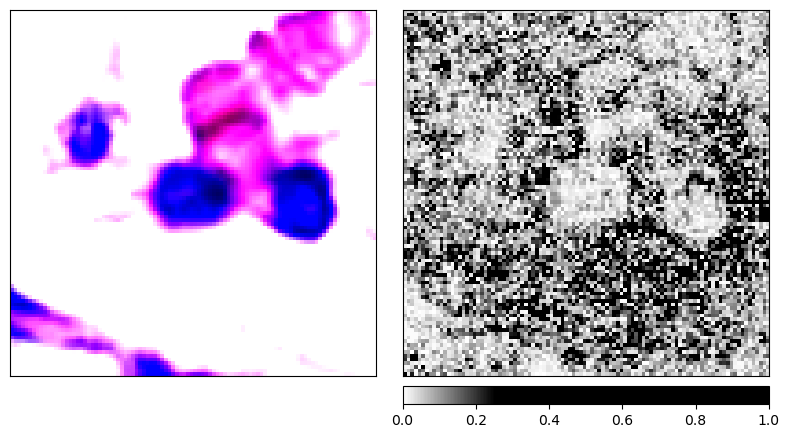

In [20]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(Net1)
gradient_shap2 = GradientShap(Net2)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
attributions_gs2 = gradient_shap2.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx2)

print("For Model 1 ")
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

print("For Model 2 ")
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

#### Occusion based attribution
Here we estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.
We run a sliding window of size 15x15 (defined via sliding_window_shapes) with a stride of 8 along both image dimensions (a defined via strides). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via baselines).

For Model 1 


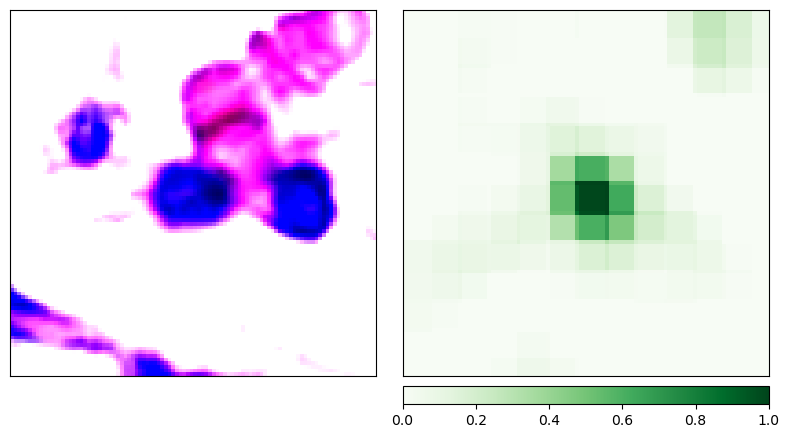

For Model 2 


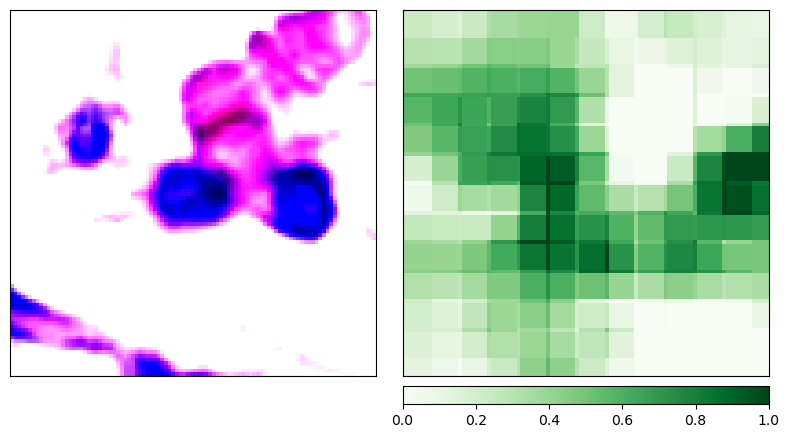

In [21]:
occlusion = Occlusion(Net1)
occlusion2 = Occlusion(Net2)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
attributions_occ2 = occlusion2.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx2,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

print("For Model 1 ")
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )
print("For Model 2 ")
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

The regions highlighted in darker green are what the model deems important for classification. For Model 1 , it is in the central region of the cell image while for Model 2, it is more scattered and the region to the middle right is what seems to be important for classifying this particular image. Since the transformed cell image itself seems abstract to me, I cannot come to a clear conclusion as to what part of the cell image the model finds significant to make decision for classification.

We run this again with a a larger occluding window.

For Model 1 


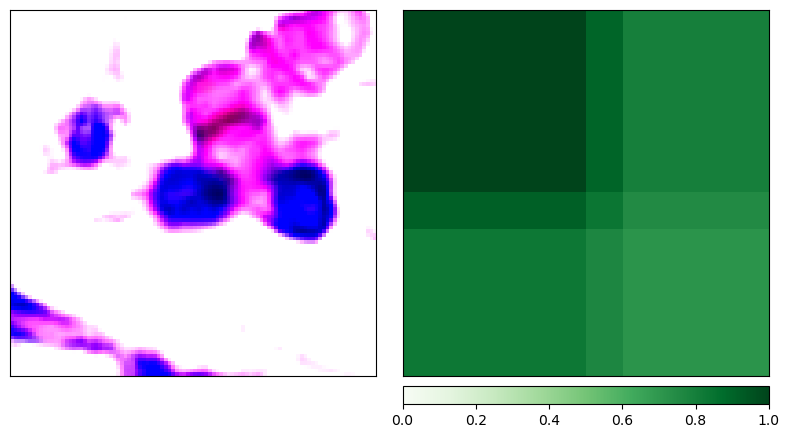

For Model 2 


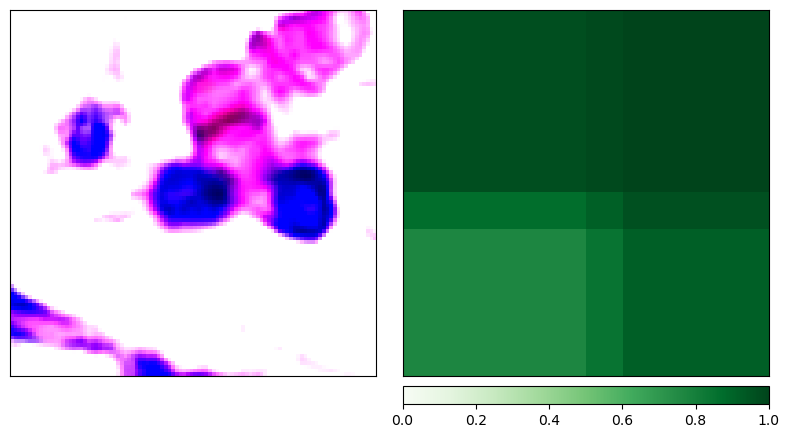

In [22]:
occlusion = Occlusion(Net1)
occlusion2 = Occlusion(Net2)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

attributions_occ2 = occlusion2.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx2,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

print("For Model 1 ")
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

print("For Model 2 ")
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

These are the interpretations of the particular image done using captum.

##### Overall, the two Designed Models did work well and managed to classify data with fairly good accuracies. Model 2, which is a modified pretrained ResNet18 model, performed better than Model 1. The classification results were converted into a Pandas DataFrame, and was written out to a .csv file named submission.csv 